# DETR football training

## TODO
- [ ] uprządkuj dataset - niepotrzebnie go przerabiałeś bo metoda transform przyjmuje obiekty w formacie coco podobnym do tego w dataset roboflow
- [ ] załaduj większy set danych treningowych od Mikołaja


## Prep

In [ ]:
%pip install -U -q datasets transformers[torch] evaluate timm albumentations accelerate roboflow

In [ ]:
!nvidia-smi

In [2]:
#checkpoint = "facebook/detr-resnet-50-dc5" # DETR
checkpoint = "SenseTime/deformable-detr" #Deformable DETR
my_checkpoint = "deformable-detr-football-finetuned"


Little helper to check if we are in Google Colab and to handle imports

In [3]:
try:
    from google.colab import drive
    from google.colab import userdata
    in_colab = True
except ImportError:
    from dotenv import load_dotenv
    in_colab = False

## Dataset

### Download dataset

In [ ]:
import os
from roboflow import Roboflow


dataset_version = 1
dataset_location = "../data/training"

if in_colab:
     rf_api_key = userdata.get("ROBOFLOW_API_KEY")
else:
    load_dotenv(dotenv_path='../config/.env')
    rf_api_key = os.getenv("ROBOFLOW_API_KEY")

rf = Roboflow(api_key=rf_api_key)
project = rf.workspace("sport-cv").project("football-players-detection-3zvbc-fynld")
version = project.version(2)
robo_dataset = version.download("coco", location=dataset_location)
print("loaded dataset to", dataset_location)



In [37]:
import json
from datasets import Dataset, DatasetDict
from PIL import Image
import numpy as np
import os

def load_coco_dataset(json_file, dataset_base_path, split):
    # Wczytaj dane JSON
    with open(json_file, 'r', encoding='utf-8') as f:
        coco_data = json.load(f)
    print(coco_data)
    dataset_dict = {
        'image_id': [],
        'image': [],
        'objects': [],
        'width': [],
        'height': []
    }

    image_id_to_annotations = {}
    for ann in coco_data['annotations']:
        image_id = ann['image_id']
        if image_id not in image_id_to_annotations:
            image_id_to_annotations[image_id] = []
        image_id_to_annotations[image_id].append(ann)

    for img in coco_data['images']:
        img_id = img['id']
        img_path = os.path.join(dataset_base_path, split, img['file_name'])
        
        image = Image.open(img_path)
        
        img_annotations = image_id_to_annotations.get(img_id, [])
        
        objects = {
            'id': [],
            'area': [],
            'bbox': [],
            'category': []
        }
        
        for ann in img_annotations:
            objects['id'].append(ann['category_id'])
            objects['area'].append(ann['area'])
            objects['bbox'].append(ann['bbox'])
            # Znajdź nazwę kategorii
            category_name = next(
                cat['name'] for cat in coco_data['categories'] 
                if cat['id'] == ann['category_id']
            )
            objects['category'].append(category_name)

        # Dodaj do słownika dataset
        dataset_dict['image_id'].append(img_id)
        dataset_dict['image'].append(image)
        dataset_dict['objects'].append(objects)
        dataset_dict['width'].append(img['width'])
        dataset_dict['height'].append(img['height'])

    return Dataset.from_dict(dataset_dict)

dataset_base_path = robo_dataset.location  
train_json = os.path.join(dataset_base_path, "train", "_annotations.coco.json")
val_json = os.path.join(dataset_base_path, "valid", "_annotations.coco.json")
test_json = os.path.join(dataset_base_path, "test", "_annotations.coco.json")

# Load datasets for each split
train_dataset = load_coco_dataset(train_json, dataset_base_path, 'train')
val_dataset = load_coco_dataset(val_json, dataset_base_path, 'valid')
test_dataset = load_coco_dataset(test_json, dataset_base_path, 'test')

# Combine into a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

dataset

{'info': {'year': '2025', 'version': '2', 'description': 'Exported from roboflow.com', 'contributor': '', 'url': 'https://public.roboflow.com/object-detection/undefined', 'date_created': '2025-02-06T23:08:16+00:00'}, 'licenses': [{'id': 1, 'url': 'https://creativecommons.org/licenses/by/4.0/', 'name': 'CC BY 4.0'}], 'categories': [{'id': 0, 'name': 'football-players-detection', 'supercategory': 'none'}, {'id': 1, 'name': 'ball', 'supercategory': 'football-players-detection'}, {'id': 2, 'name': 'goalkeeper', 'supercategory': 'football-players-detection'}, {'id': 3, 'name': 'player', 'supercategory': 'football-players-detection'}, {'id': 4, 'name': 'referee', 'supercategory': 'football-players-detection'}], 'images': [{'id': 0, 'license': 1, 'file_name': 'a9f16c_2_2_png.rf.d27a85891cbdba02a947271cd128acd2.jpg', 'height': 1080, 'width': 1920, 'date_captured': '2025-02-06T23:08:16+00:00'}, {'id': 1, 'license': 1, 'file_name': '2e57b9_5_7_png.rf.cef81105e8148118367d4b67347d0fd9.jpg', 'heigh

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'objects', 'width', 'height'],
        num_rows: 298
    })
    validation: Dataset({
        features: ['image_id', 'image', 'objects', 'width', 'height'],
        num_rows: 49
    })
    test: Dataset({
        features: ['image_id', 'image', 'objects', 'width', 'height'],
        num_rows: 25
    })
})

In [33]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [32]:
print(train_dataset[0])

{'image_id': 0, 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080 at 0x32F531160>, 'objects': {'area': [602.064, 576.0, 960.323, 1154.825, 525.0, 544.0, 860.0, 920.0, 570.0, 966.0, 903.671, 874.0, 680.0, 1026.0, 784.0, 1064.0, 1197.0, 1352.0, 969.0, 1980.0, 103.2, 891.701, 569.824, 494.72], 'bbox': [[1117.0, 299.0, 17.76, 33.9], [947.0, 324.0, 16.0, 36.0], [834.0, 357.0, 22.24, 43.18], [584.0, 398.0, 22.35, 51.67], [929.0, 291.0, 15.0, 35.0], [706.0, 337.0, 17.0, 32.0], [1002.0, 330.0, 20.0, 43.0], [681.0, 366.0, 23.0, 40.0], [1514.0, 327.0, 15.0, 38.0], [264.0, 387.0, 21.0, 46.0], [520.0, 422.0, 20.51, 44.06], [555.0, 381.0, 19.0, 46.0], [1248.0, 364.0, 17.0, 40.0], [1446.0, 442.0, 19.0, 54.0], [942.0, 420.0, 16.0, 49.0], [711.0, 514.0, 19.0, 56.0], [1372.0, 510.0, 21.0, 57.0], [1666.0, 410.0, 26.0, 52.0], [883.0, 419.0, 19.0, 51.0], [1116.0, 545.0, 36.0, 55.0], [1221.0, 323.0, 10.32, 10.0], [1144.0, 286.0, 23.64, 37.72], [978.0, 276.0, 16.29, 34.98], [781.0, 2

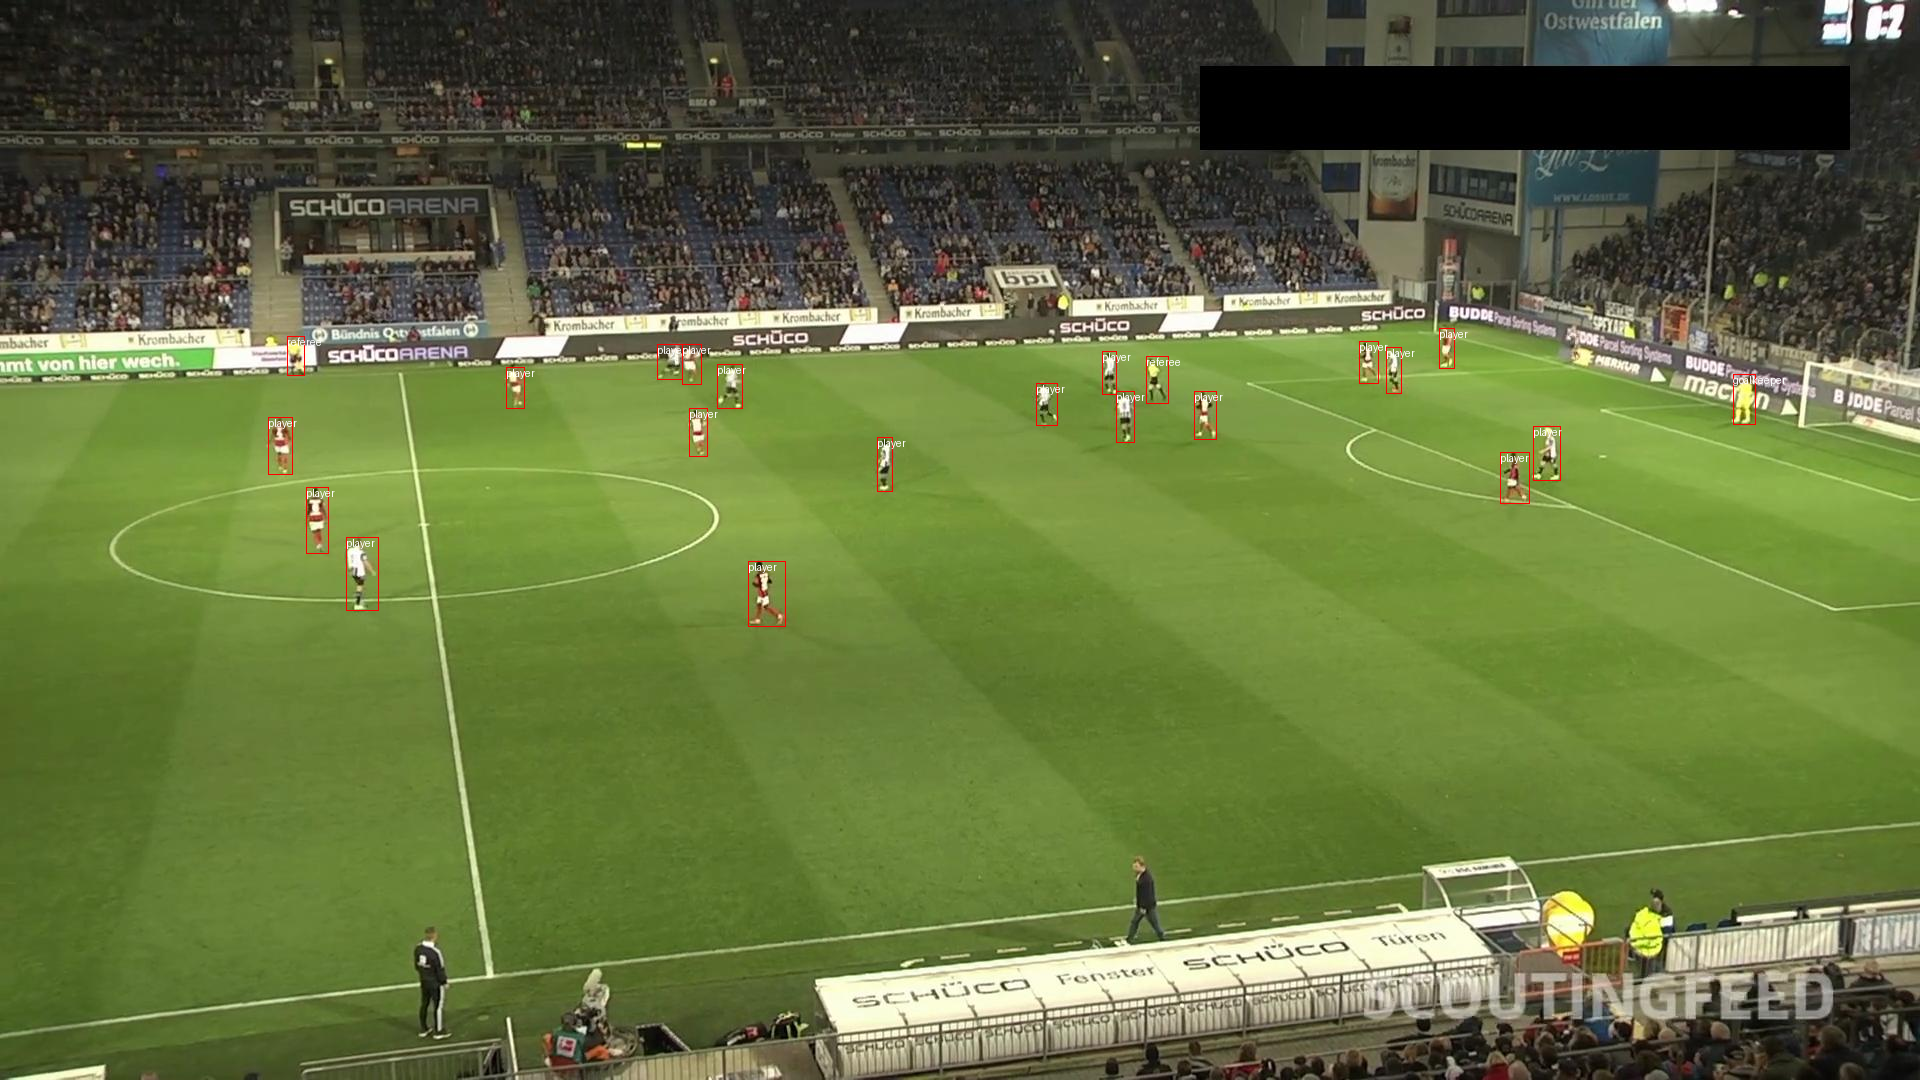

In [34]:
import numpy as np
from PIL import Image, ImageDraw


def draw_image_from_idx(dataset, idx):
    sample = dataset[idx]
    image = sample["image"]
    annotations = sample["objects"]
    draw = ImageDraw.Draw(image)
    width, height = sample["width"], sample["height"]

    for i in range(len(annotations["id"])):
        box = annotations["bbox"][i]
        class_idx = annotations["id"][i]
        x, y, w, h = tuple(box)
        if max(box) > 1.0:
            x1, y1 = int(x), int(y)
            x2, y2 = int(x + w), int(y + h)
        else:
            x1 = int(x * width)
            y1 = int(y * height)
            x2 = int((x + w) * width)
            y2 = int((y + h) * height)
        draw.rectangle((x1, y1, x2, y2), outline="red", width=1)
        draw.text((x1, y1), annotations["category"][i], fill="white")
    return image


import random
random_idx = random.randint(0, len(train_dataset) - 1)
draw_image_from_idx(dataset=train_dataset, idx=random_idx)

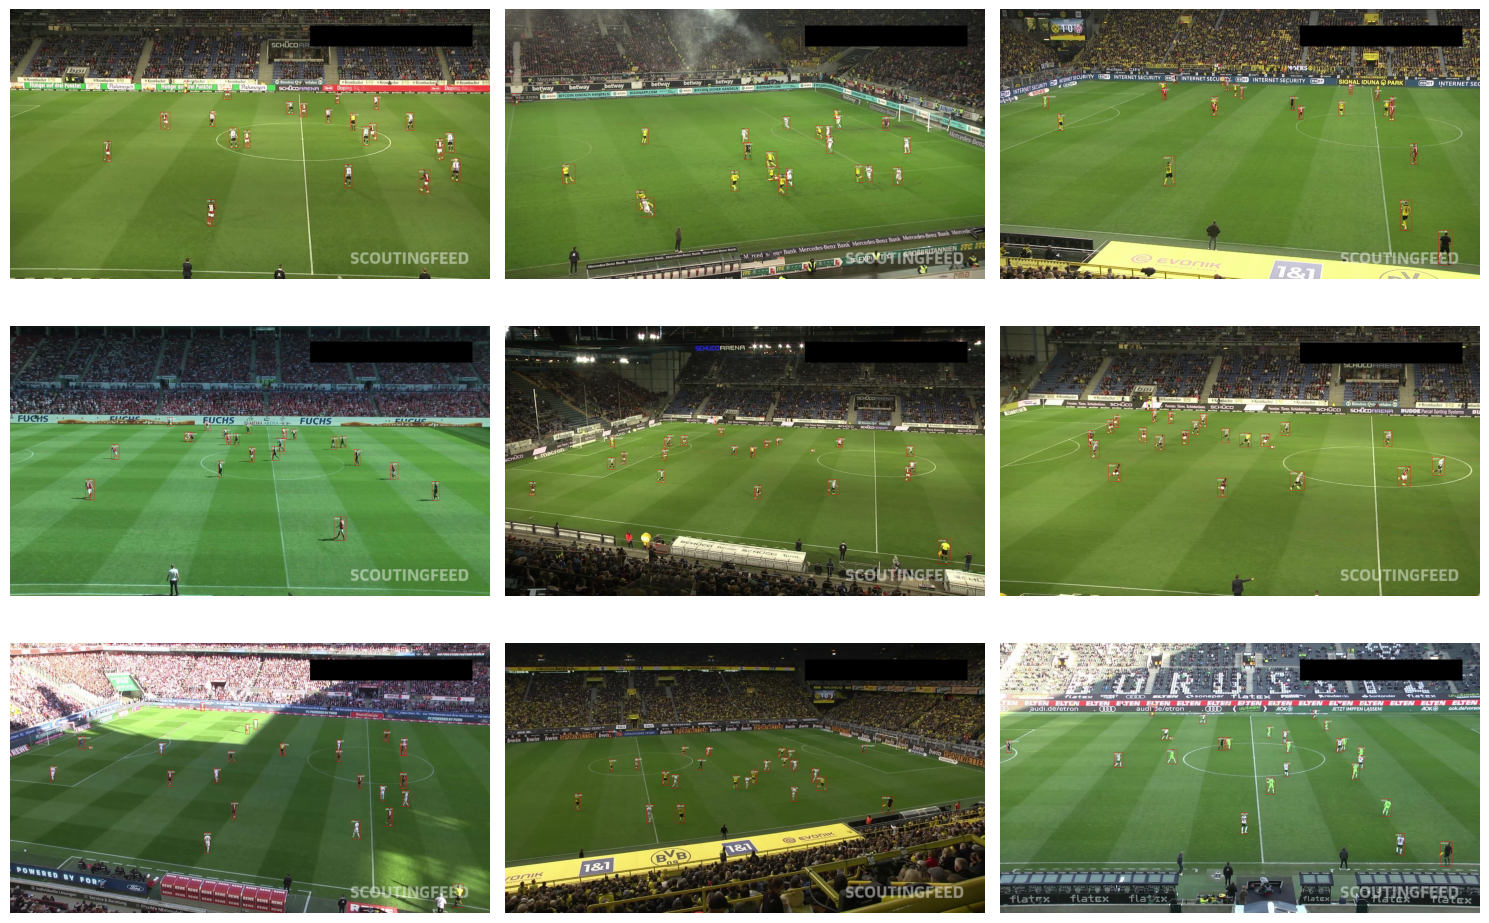

In [35]:
import matplotlib.pyplot as plt


import random

def plot_images(dataset, num_images=9):
    indices = random.sample(range(len(dataset)), num_images)
    num_rows = num_images // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols

        # Draw image
        image = draw_image_from_idx(dataset, idx)

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


# Now use the function to plot images
plot_images(train_dataset)


### Preprocessing the Dataset

In [15]:
from transformers import AutoImageProcessor

checkpoint = checkpoint
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [16]:
import albumentations
import numpy as np

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
        bbox_params=albumentations.BboxParams(
        format="coco",
        label_fields=["category"],
        clip=True,
        check_each_transform=True #TODO: sprawdzić działanie na False
    ),
)

Once we initialize all the transformations, we need to make a function which formats the annotations and returns the a list of annotation with a very specific format.

This is because the image_processor expects the annotations to be in the following format: {'image_id': int, 'annotations': List[Dict]}, where each dictionary is a COCO object annotation.

In [17]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [18]:
# transforming a batch

def transform_aug_ann(examples):
    print("examples", examples)
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["id"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [30]:
# Apply transformations for both train and test dataset

train_dataset_transformed = train_dataset.with_transform(transform_aug_ann)
test_dataset_transformed = test_dataset.with_transform(transform_aug_ann)

A collate_fn is responsible for taking a list of samples from a dataset and converting them into a batch suitable for model’s input format.

In general a DataCollator typically performs tasks such as padding, truncating etc. In a custom collate function, we often define what and how we want to group the data into batches or simply, how to represent each batch.

Data collator mainly puts the data together and then preprocesses them. Let’s make our collate function.

In [34]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

## Training

In [ ]:
from huggingface_hub import login
try:
    from google.colab import userdata
    login(token=userdata.get('HF_TOKEN'))
except ImportError:
    login()

In [ ]:
from transformers import AutoModelForObjectDetection

id2label = {0: "football-players-detection", 1: "ball", 2: "goalkeeper", 3: "player", 4: "referee"}
label2id = {v: k for k, v in id2label.items()}


model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

In [ ]:
from transformers import TrainingArguments
from transformers import Trainer

# Define the training arguments

training_args = TrainingArguments(
    output_dir=my_checkpoint,
    per_device_train_batch_size=8,
    num_train_epochs=5,
    fp16=True,
    logging_steps=100,
    learning_rate=1e-4,
    weight_decay=1e-4,
    warmup_steps=100,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
)

# Define the trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset_transformed,
    eval_dataset=test_dataset_transformed,
    tokenizer=image_processor,
)

trainer.train()


## Testing


If you save the model to the hub, you need to change the model to your own username and the name of the model.

In [ ]:
import requests
from transformers import pipeline

# make the object detection pipeline

obj_detector = pipeline(
    "object-detection", 
    model= my_checkpoint, 
    threshold=0.3
)
results = obj_detector(train_dataset[0]["image"])

print(results)

In [ ]:
image = train_dataset[0]["image"]
image

In [23]:
from PIL import ImageFont

def plot_results(image, results, threshold=0.7):
    image = Image.fromarray(np.uint8(image))
    draw = ImageDraw.Draw(image)
    for result in results:
        score = result["score"]
        label = result["label"]
        box = list(result["box"].values())
        if score > threshold:
            x, y, x2, y2 = tuple(box)
            draw.rectangle((x, y, x2, y2), outline="red", width=1)
            draw.text(
                (x + 0.5, y - 0.5),
                text=str(label),
                fill="green" if score > 0.7 else "red",
                font=ImageFont.load_default(size=16) # Increased font size
            )
    return image

In [ ]:
plot_results(image, results, threshold=0.5)


In [ ]:
def predict(image, pipeline, threshold=0.1):
    results = pipeline(image)
    return plot_results(image, results, threshold)


# Let's test for another test image

img = test_dataset[0]["image"]
predict(img, obj_detector)

In [ ]:
from tqdm.auto import tqdm


def plot_images(dataset, indices):
    """
    Plot images and their annotations.
    """
    indices = random.sample(range(len(dataset)), len(indices))
    num_rows = len(indices) // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))


    for i, idx in tqdm(enumerate(indices), total=len(indices)):
        row = i // num_cols
        col = i % num_cols

        # Draw image
        image = predict(dataset[idx]["image"], obj_detector)

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


plot_images(test_dataset, range(6))